In [1]:
import os
import sys
import numpy as np
from scipy import signal
import pickle
import time
import neuron
from neuron import h
from neuron import gui
import matplotlib.pyplot as plt
from neuron import h
import multiprocessing
import numpy as np
import math
import sys
plt.rcParams.update({'font.size': 15})

--No graphics will be displayed.


In [4]:
!nrnivmodl mod_files/

/home/mjy/project/bilinear_network/basket
cfiles =
Mod files: "mod_files//Cav1_2.mod" "mod_files//Cav1_3.mod" "mod_files//Cav2_1.mod" "mod_files//Cav3_2.mod" "mod_files//cdp5StCmod.mod" "mod_files//GOLGI_Ampa_pf_aa_det_vi.mod" "mod_files//HCN1_PC.mod" "mod_files//Kca1_1.mod" "mod_files//Kca2_2.mod" "mod_files//Kca3_1.mod" "mod_files//Kir2_3.mod" "mod_files//Kv1_1.mod" "mod_files//Kv3_4.mod" "mod_files//Kv4_3.mod" "mod_files//Leak.mod" "mod_files//Nav1_1.mod" "mod_files//Nav1_6.mod" "mod_files//PC_Gaba_det_vi_alfa1.mod" "mod_files//SC_NMDA_NR2B.mod"

Creating 'x86_64' directory for .o files.

MODOBJS= ./Cav1_2.o ./Cav1_3.o ./Cav2_1.o ./Cav3_2.o ./cdp5StCmod.o ./GOLGI_Ampa_pf_aa_det_vi.o ./HCN1_PC.o ./Kca1_1.o ./Kca2_2.o ./Kca3_1.o ./Kir2_3.o ./Kv1_1.o ./Kv3_4.o ./Kv4_3.o ./Leak.o ./Nav1_1.o ./Nav1_6.o ./PC_Gaba_det_vi_alfa1.o ./SC_NMDA_NR2B.o
 -> Compiling mod_func.cpp
 -> NMODL ../mod_files//Cav1_2.mod
 -> NMODL ../mod_files//Cav1_3.mod
 -> NMODL ../mod_files//Cav2_1.mod
Translating Ca

In [3]:
from neuron import h 
from basket import Basket

import multiprocessing

cell = Basket()


6633 lines read

morphology/01bc.ASC problems


Main branch starting at line 168 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 3401 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 4942 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 5437 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 6075 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 6282 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 6332 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma


In [9]:
# ---------------- Purkinje + random synapses + connecting dendrite ----------------
import os
import numpy as np
import matplotlib.pyplot as plt
from neuron import h

# ==== pt3d ====
def _pt3d(sec):
    n3d = int(h.n3d(sec=sec))
    if n3d > 1:
        xs = [h.x3d(i, sec=sec) for i in range(n3d)]
        ys = [h.y3d(i, sec=sec) for i in range(n3d)]
        zs = [h.z3d(i, sec=sec) for i in range(n3d)]
        ds = [h.diam3d(i, sec=sec) for i in range(n3d)]
    else:
        xs = [0.0, sec.L]; ys = [0.0, 0.0]; zs = [0.0, 0.0]; ds = [sec.diam, sec.diam]
    return np.asarray(xs), np.asarray(ys), np.asarray(zs), np.asarray(ds)

# ==== rotations & projection ====
def _rot_z(th): c,s=np.cos(th),np.sin(th); return np.array([[c,-s,0],[s,c,0],[0,0,1]],float)
def _rot_y(th): c,s=np.cos(th),np.sin(th); return np.array([[c,0,s],[0,1,0],[-s,0,c]],float)
def _rot_x(th): c,s=np.cos(th),np.sin(th); return np.array([[1,0,0],[0,c,-s],[0,s,c]],float)

def _project_xyz(xs, ys, zs, view):
    xs,ys,zs = np.asarray(xs), np.asarray(ys), np.asarray(zs)
    P = np.vstack([xs,ys,zs])
    if isinstance(view,(list,tuple)) and len(view)>=2 and view[0]=='plane':
        plane = view[1]
        if plane=='xy': return xs, ys
        if plane=='xz': return xs, zs
        if plane=='yz': return ys, zs
        raise ValueError("plane must be 'xy'|'xz'|'yz'")
    if isinstance(view,(list,tuple)) and len(view)==3 and view[0]=='az_el':
        az, el = np.deg2rad(view[1]), np.deg2rad(view[2])
        R = _rot_x(-el) @ _rot_z(az)
        Q = R @ P
        return Q[0,:], Q[1,:]
    if isinstance(view,(list,tuple)) and len(view)==4 and view[0]=='euler':
        yaw,pitch,roll = map(np.deg2rad, view[1:4])
        R = _rot_z(yaw) @ _rot_y(pitch) @ _rot_x(roll)
        Q = R @ P
        return Q[0,:], Q[1,:]
    raise ValueError("invalid view")

# ==== helpers ====
def _is_soma(sec): return 'soma' in sec.name().lower()
def _is_axon(sec): return 'axon' in sec.name().lower()

def _soma_center_in_view(view):
    pts=[]
    for s in h.allsec():
        if _is_soma(s):
            xs,ys,zs,_ = _pt3d(s)
            X,Y = _project_xyz(xs,ys,zs,view)
            pts.append(np.c_[X,Y])
    return (np.vstack(pts).mean(axis=0) if pts else np.array([0.0,0.0]))

def _sample_points_on_polyline(X, Y, n, rng):
    d = np.hypot(np.diff(X), np.diff(Y)); tot = d.sum()
    if tot<=0: return np.full(n,X[0]), np.full(n,Y[0])
    c = np.cumsum(d); u = rng.random(n)*tot
    idx = np.searchsorted(c,u,'right'); idx = np.clip(idx,0,len(d)-1)
    cprev = np.where(idx==0,0.0,c[idx-1]); t = (u-cprev)/(d[idx]+1e-12)
    x = X[idx]*(1-t)+X[idx+1]*t; y = Y[idx]*(1-t)+Y[idx+1]*t
    return x,y

def draw_purkinje_with_random_synapses(
    cell=None,
    view=('plane','xy'),
    figsize=(8,8),
    dpi=600,
    save_prefix='figure/purkinje_syn',
    dend_color='#222222',
    dend_lw_scale=0.22,
    soma_circle_radius_um=10.0,
    n_syn=100,
    frac_red=0.5,
    syn_size_red=8,
    syn_size_black=8,
    rng_seed=0,
    # —— 新增：多根连接控制 —— #
    connect_all_roots=True,       # ✅ 连接所有靠近的树突根
    connect_max_dist_um=6.0,      # 距离阈值（投影距离，单位 µm）
    connect_min_sep_deg=10.0,     # 相邻连接的最小角距，避免重叠（度）
    connect_taper_ratio=3.0,      # 粗->细的渐变比例（越大越尖）
    show_png=True
):
    import matplotlib.pyplot as plt
    os.makedirs(os.path.dirname(save_prefix), exist_ok=True)
    h.define_shape()
    rng = np.random.default_rng(rng_seed)

    # 1) soma 圆心（投影）
    soma_center = _soma_center_in_view(view)

    # 2) 收集所有树突折线 + 找每条折线上“离 soma 圆心最近的点”和该处直径
    all_segs = []           # [(X, Y, ds)]
    root_candidates = []    # [(px, py, diam_at_p, dist, theta_deg)]
    for s in h.allsec():
        if _is_axon(s) or _is_soma(s):
            continue
        xs,ys,zs,ds = _pt3d(s)
        X,Y = _project_xyz(xs,ys,zs,view)
        all_segs.append((X.copy(), Y.copy(), ds))
        # 遍历折线逐段找最近点
        for i in range(1, len(X)):
            x1,y1 = X[i-1], Y[i-1]
            x2,y2 = X[i],   Y[i]
            vx,vy = x2-x1, y2-y1
            wx,wy = soma_center[0]-x1, soma_center[1]-y1
            L2 = vx*vx + vy*vy
            if L2 <= 1e-12:
                t = 0.0
            else:
                t = (vx*wx + vy*wy) / L2
                t = max(0.0, min(1.0, t))
            px, py = x1 + t*vx, y1 + t*vy
            # 线性插值得到该点直径
            diam = float(ds[i-1]*(1-t) + ds[i]*t)
            # 与 soma 圆心的投影距离
            d = np.hypot(px - soma_center[0], py - soma_center[1])
            # 该方向的角度（用于去重）
            theta = np.degrees(np.arctan2(py - soma_center[1], px - soma_center[0]))
            root_candidates.append((px, py, diam, d, theta))

    # 3) 画树突主干
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.set_aspect('equal', adjustable='datalim'); ax.axis('off')
    for (X,Y,ds) in all_segs:
        for i in range(1, len(X)):
            lw = max(0.3, float(ds[i]) * dend_lw_scale)
            ax.plot([X[i-1], X[i]],[Y[i-1],Y[i]], color=dend_color,
                    lw=lw, solid_capstyle='round', zorder=2)

    # 4) 随机突触
    lengths = np.array([np.hypot(np.diff(X), np.diff(Y)).sum() for (X,Y,_) in all_segs])
    if lengths.sum()>0 and len(all_segs)>0:
        probs = lengths / lengths.sum()
        chosen = rng.choice(len(all_segs), size=n_syn, p=probs)
        syn_x, syn_y = [], []
        for idx in chosen:
            X,Y,_ = all_segs[idx]
            x1,y1 = _sample_points_on_polyline(X,Y,1,rng)
            syn_x.append(x1[0]); syn_y.append(y1[0])
        syn_x, syn_y = np.asarray(syn_x), np.asarray(syn_y)
    else:
        syn_x = np.array([]); syn_y = np.array([])

    k_red = int(round(n_syn * frac_red))
    order = np.arange(len(syn_x)); rng.shuffle(order)
    red_idx, blk_idx = order[:k_red], order[k_red:]
    if len(red_idx): ax.scatter(syn_x[red_idx], syn_y[red_idx], s=syn_size_red, c='#d62828', zorder=5)
    if len(blk_idx): ax.scatter(syn_x[blk_idx], syn_y[blk_idx], s=syn_size_black, c='#111111', zorder=4)

    # 5) 画 soma 圆
    soma_disc = plt.Circle((float(soma_center[0]), float(soma_center[1])),
                           soma_circle_radius_um, color='#111111', zorder=6)
    ax.add_patch(soma_disc)

    # 6) 多根连接段（可选）
    if connect_all_roots and len(root_candidates):
        # 只保留离 soma 足够近的候选（从圆边算距离更合理；d_edge = d - soma_radius）
        filtered = []
        for px,py,diam,d,theta in root_candidates:
            d_edge = max(d - soma_circle_radius_um, 0.0)
            if d_edge <= connect_max_dist_um:
                filtered.append((px,py,diam,d_edge,theta))
        if filtered:
            # 按角度做非极大值抑制：同方向的保留距离最近的一个
            filtered.sort(key=lambda x: (x[4], x[3]))  # 先按角度，再按距圆边距离
            kept = []
            for cand in filtered:
                keep = True
                for (_,_,_,_,th0) in kept:
                    if abs((cand[4]-th0+180)%360-180) < connect_min_sep_deg:
                        # 与已有角度太近，只保留更近的那个
                        if cand[3] < [k[3] for k in kept if k[4]==th0][0]:
                            # 用更近的替换
                            kept = [k for k in kept if k[4]!=th0] + [cand]
                        keep = False
                        break
                if keep:
                    kept.append(cand)

            # 逐个画连接段（从圆周出发，线宽渐细）
            for px,py,diam,d_edge,theta in kept:
                vx, vy = px - soma_center[0], py - soma_center[1]
                L = np.hypot(vx, vy)
                if L <= 1e-9:
                    continue
                ux, uy = vx/L, vy/L
                # 起点：soma 圆边，略微向外推进一点点，避免和圆边缘锯齿
                start = np.array([soma_center[0] + ux * (soma_circle_radius_um + 0.1),
                                  soma_center[1] + uy * (soma_circle_radius_um + 0.1)])
                end   = np.array([px, py])
                # 目标末端线宽（匹配树突本地粗细）
                end_lw = max(0.3, float(diam) * dend_lw_scale)
                start_lw = max(end_lw * connect_taper_ratio, end_lw*1.25)
                # 分段画出：线宽线性插值
                nseg = max(int(np.ceil(L/2.0)), 6)  # 2 µm 一段，至少 6 段
                ts = np.linspace(0, 1, nseg+1)
                for i in range(nseg):
                    p1 = start*(1-ts[i]) + end*ts[i]
                    p2 = start*(1-ts[i+1]) + end*ts[i+1]
                    lw = (start_lw*(1-ts[i]) + end_lw*ts[i])
                    ax.plot([p1[0], p2[0]], [p1[1], p2[1]],
                            color=dend_color, lw=lw,
                            solid_capstyle='round', zorder=3)

    # 7) 视域 & 保存（白底）
    ax.relim(); ax.autoscale()
    x0,x1 = ax.get_xlim(); y0,y1 = ax.get_ylim()
    pad_x, pad_y = (x1-x0)*0.06, (y1-y0)*0.06
    ax.set_xlim(x0-pad_x, x1+pad_x); ax.set_ylim(y0-pad_y, y1+pad_y)

    png_path = f'{save_prefix}.png'
    svg_path = f'{save_prefix}.svg'
    fig.savefig(png_path, dpi=dpi, bbox_inches='tight', pad_inches=0.02,
                facecolor='white', edgecolor='none', transparent=False)
    fig.savefig(svg_path, dpi=dpi, bbox_inches='tight', pad_inches=0.02,
                facecolor='white', edgecolor='none', transparent=False)
    if show_png: plt.show()
    print(f"Saved:\n  {png_path}\n  {svg_path}")



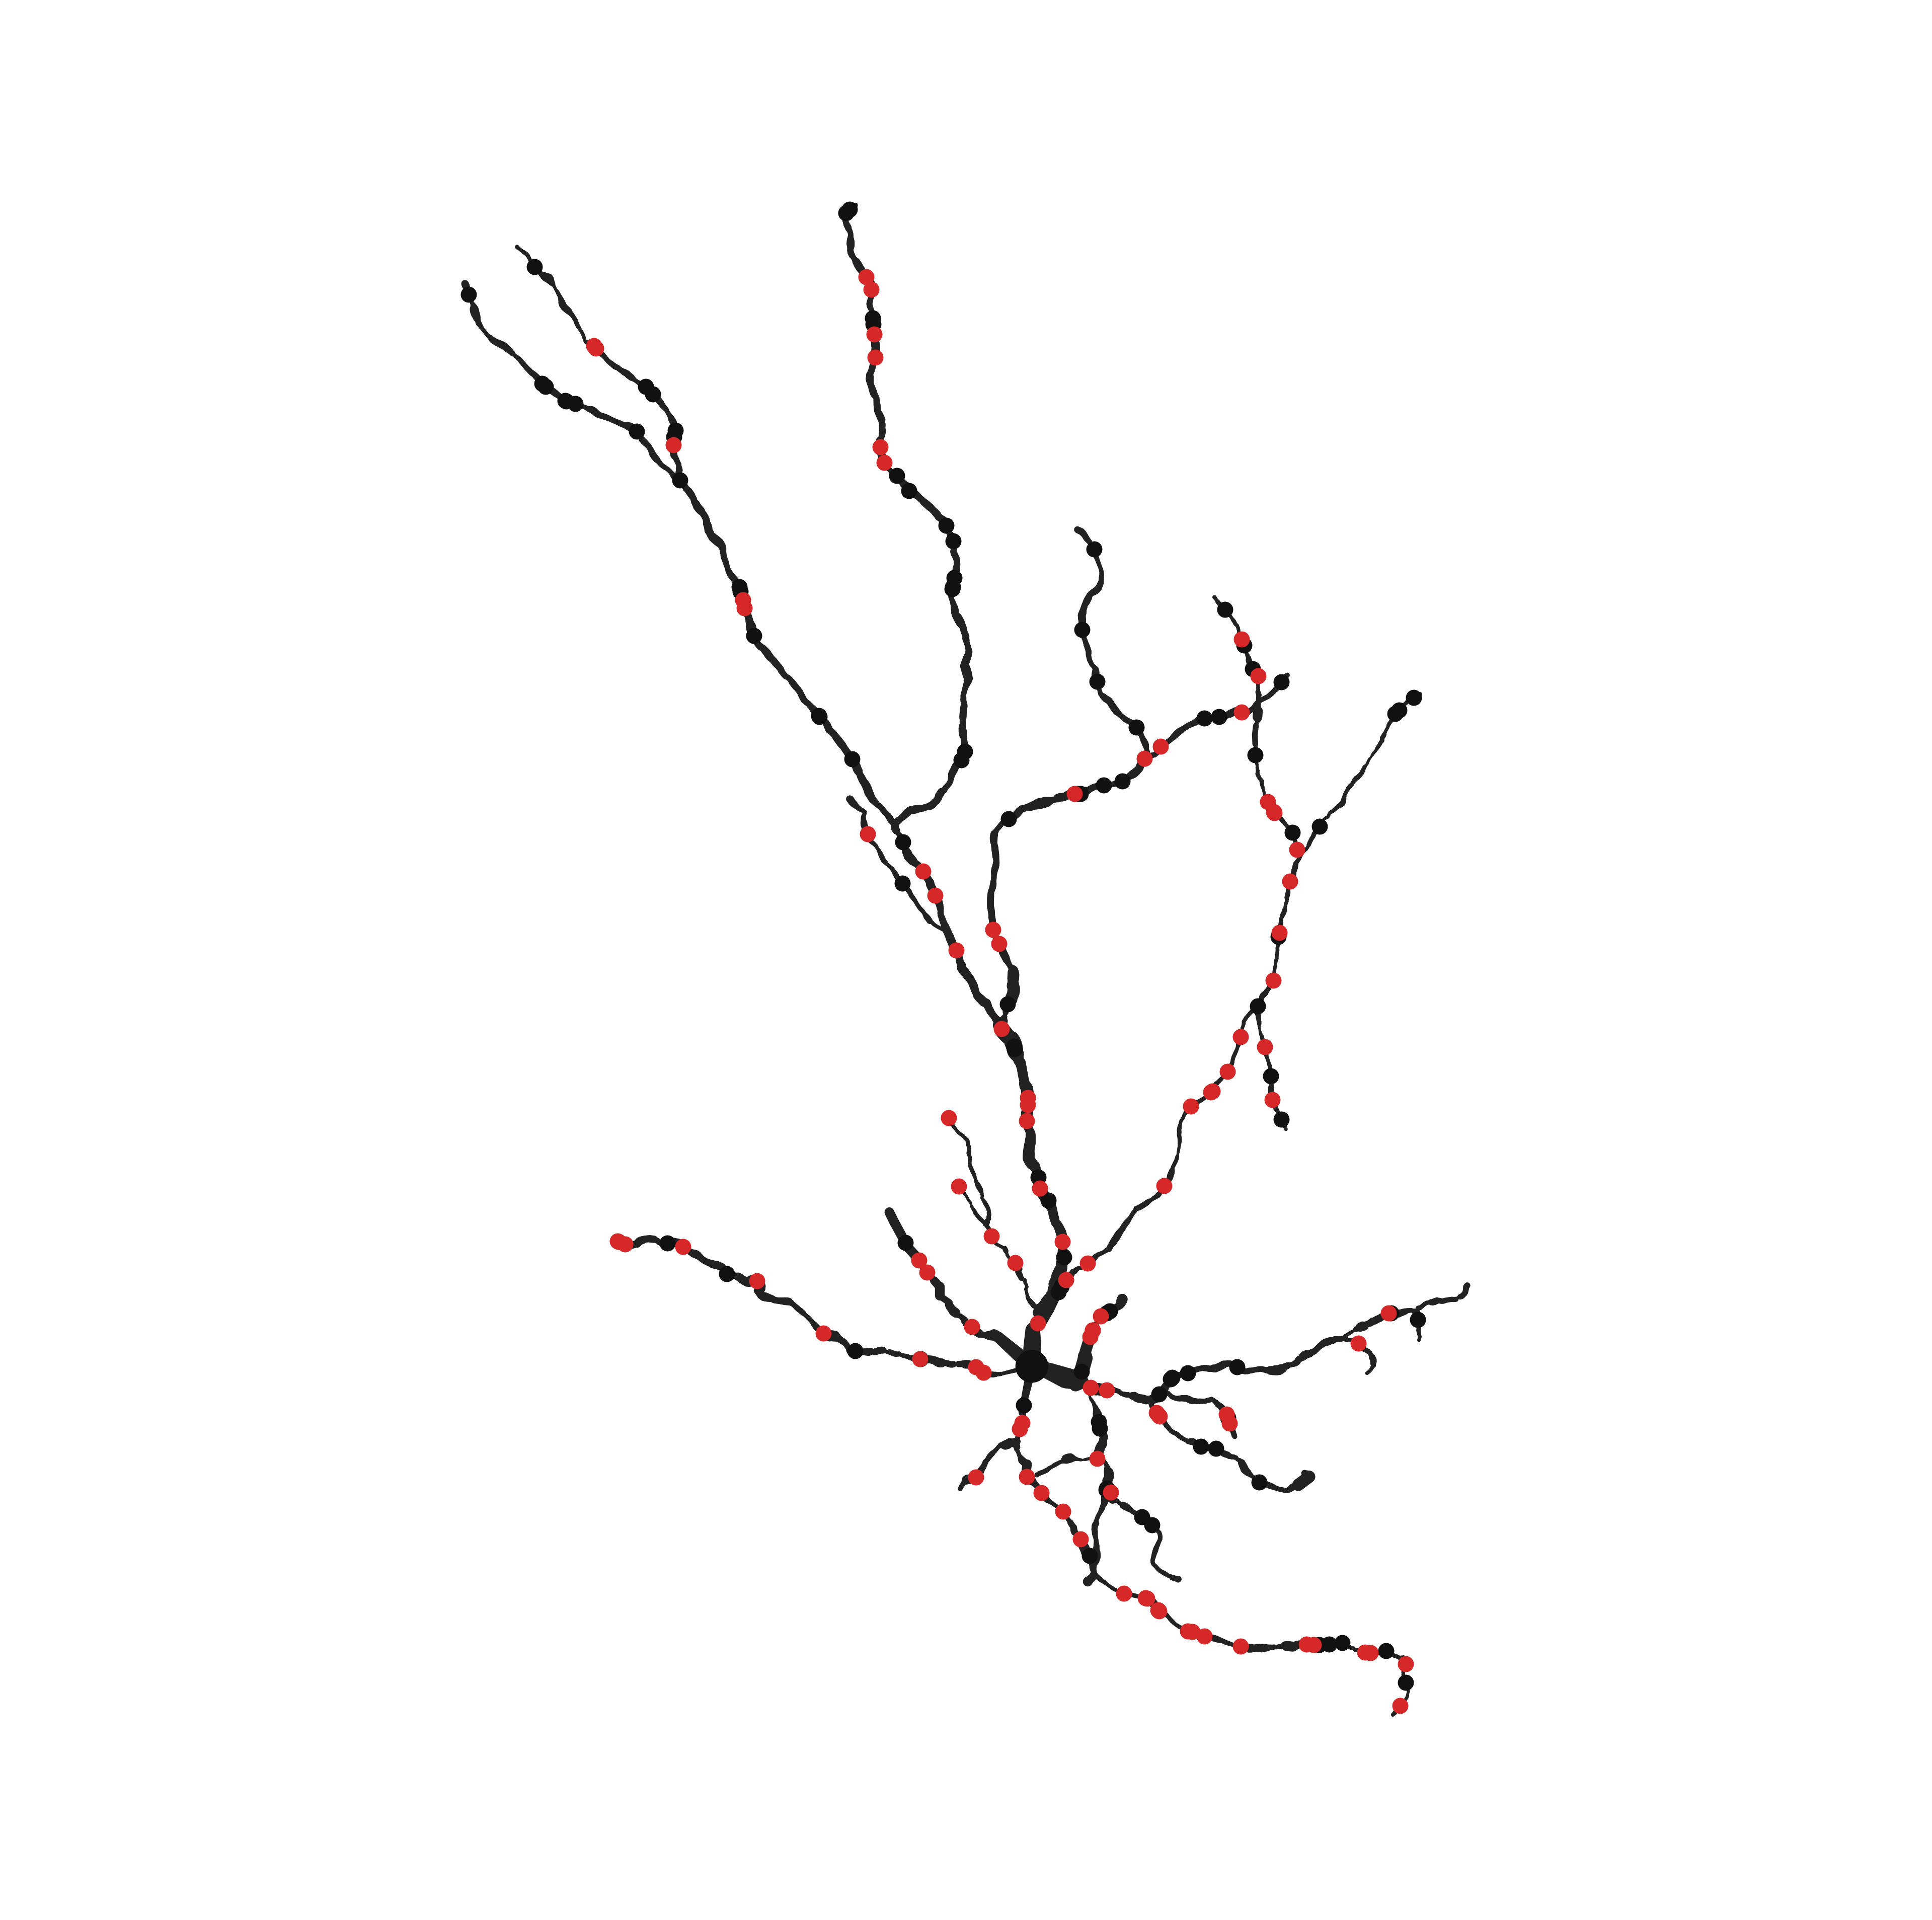

Saved:
  figure/basket_az30_el60_connect_all.png
  figure/basket_az30_el60_connect_all.svg


In [18]:
draw_purkinje_with_random_synapses(
    cell,
    view=('az_el', 0, 0),
    dend_lw_scale=2.5,
    soma_circle_radius_um=2.0,
    n_syn=200, frac_red=0.5,
    connect_all_roots=True,        # 多根连接
    connect_max_dist_um=5.0,
    connect_min_sep_deg=8.0,
    connect_taper_ratio=0.5,
    save_prefix='figure/basket_az30_el60_connect_all'
)
